# **SSCS - Training**

Developed by André Paiva

Based on SSCS Dataset created by Helena Cuesta and Emilia Gómez

## 1 - Initialization

In [ ]:
import time
import numpy as np
import tensorflow as tf
import sscs
import matplotlib.pyplot as plt

## 2 - Download and extract dataset SSCS

In [2]:
sscs.download()

SSCS Dataset found.
SSCS Dataset already extracted.
Done.


## 3 - Training VoasCNN

In [ ]:
ds_train = sscs.get_dataset(split='train', end_index=1000)
ds_val = sscs.get_dataset(split='validate', end_index=300)
ds_test = sscs.get_dataset(split='test', end_index=300)

In [ ]:
'''
ckpt_dir = './Checkpoints/mask_voas_treino1.keras'
#ckpt_dir = './Checkpoints/mask_voas_treino2_tracked.keras'
#ckpt_dir = './Checkpoints/mask_voas_treino3_tracked.keras'
#ckpt_dir = './Checkpoints/mask_voas_treino4_tracked.keras'
#ckpt_dir = './Checkpoints/mask_voas_treino5_tracked.keras'
#ckpt_dir = './Checkpoints/mask_voas_treino6_tracked.keras'
mask_voas_cnn = sscs.mask_voas_cnn_model(l_rate = 2e-3)

print(mask_voas_cnn.summary())

sscs.load_weights(mask_voas_cnn, ckpt_dir=ckpt_dir)
#sscs.train(mask_voas_cnn, ds_train, ds_val, epochs=15, save_model=True, ckpt_dir=ckpt_dir, log_folder='mask_voas_cnn')  
'''

In [5]:
ckpt_dir = './Checkpoints/mask_voas_v2_treino1_tracked.keras'
mask_voas_v2 = sscs.mask_voas_cnn_v2_model(l_rate = 5e-3)

print(mask_voas_v2.summary())

Model: "MaskVoasCNNv2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 360, 256, 1)]        0         []                            
                                                                                                  
 downscale (Resizing)        (None, 90, 128, 1)           0         ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 90, 128, 1)           4         ['downscale[0][0]']           
 Normalization)                                                                                   
                                                                                                  
 conv1 (Conv2D)              (None, 90, 128, 32)          320       ['batch_normalizat

In [6]:
sscs.load_weights(mask_voas_v2, ckpt_dir=ckpt_dir)
#sscs.train(mask_voas_v2, ds_train, ds_val, epochs=30, save_model=True, ckpt_dir=ckpt_dir, log_folder='mask_voas_v2')  

## 4 - Evaluation with F-Score

In [7]:
#songs = sscs.pick_songlist(amount=805, split='test')
songs = sscs.pick_songlist(amount=300, split='test')

def multivoice_f_score(song):
    mix, s, a, t, b = sscs.read_all_voice_splits(song)
    s_pred, a_pred, t_pred, b_pred = mask_voas_v2.predict(mix)

    mix = np.moveaxis(mix, 0, 1).reshape(360, -1)
    s = np.moveaxis(s, 0, 1).reshape(360, -1)
    a = np.moveaxis(a, 0, 1).reshape(360, -1)
    t = np.moveaxis(t, 0, 1).reshape(360, -1)
    b = np.moveaxis(b, 0, 1).reshape(360, -1)

    s_pred_postproc = sscs.prediction_postproc(s_pred).astype(np.float32)
    a_pred_postproc = sscs.prediction_postproc(a_pred).astype(np.float32)
    t_pred_postproc = sscs.prediction_postproc(t_pred).astype(np.float32)
    b_pred_postproc = sscs.prediction_postproc(b_pred).astype(np.float32)
    mix_pred_postproc = s_pred_postproc + a_pred_postproc + t_pred_postproc + b_pred_postproc
    mix_pred_postproc = sscs.vectorized_downsample_limit(mix_pred_postproc)

    s_fscore = sscs.f_score(s, s_pred_postproc)
    a_fscore = sscs.f_score(a, a_pred_postproc)
    t_fscore = sscs.f_score(t, t_pred_postproc)
    b_fscore = sscs.f_score(b, b_pred_postproc)

    return [s_fscore, a_fscore, t_fscore, b_fscore]

#f_scores = np.array(list(map(multivoice_f_score, songs)))
#f_scores = f_scores.T
#np.save('./Evaluation_Data/mask_voas_v2_f-scores_treino1_tracked.npy', f_scores)

In [8]:
f_scr_v2 = np.load("./Evaluation_Data/mask_voas_v2_f-scores_treino1_tracked.npy")
#f_scr_v2 = np.load("./Evaluation_Data/f-scores_treino1_full_test.npy")

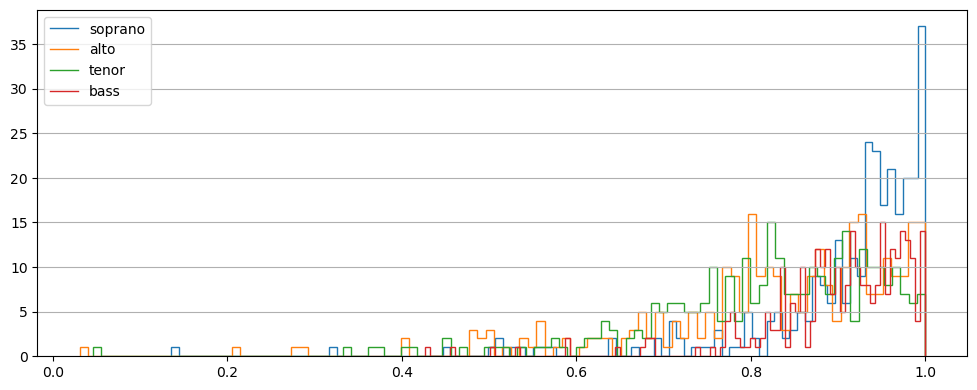

In [9]:
sscs.joint_f_histograms(f_scr_v2)

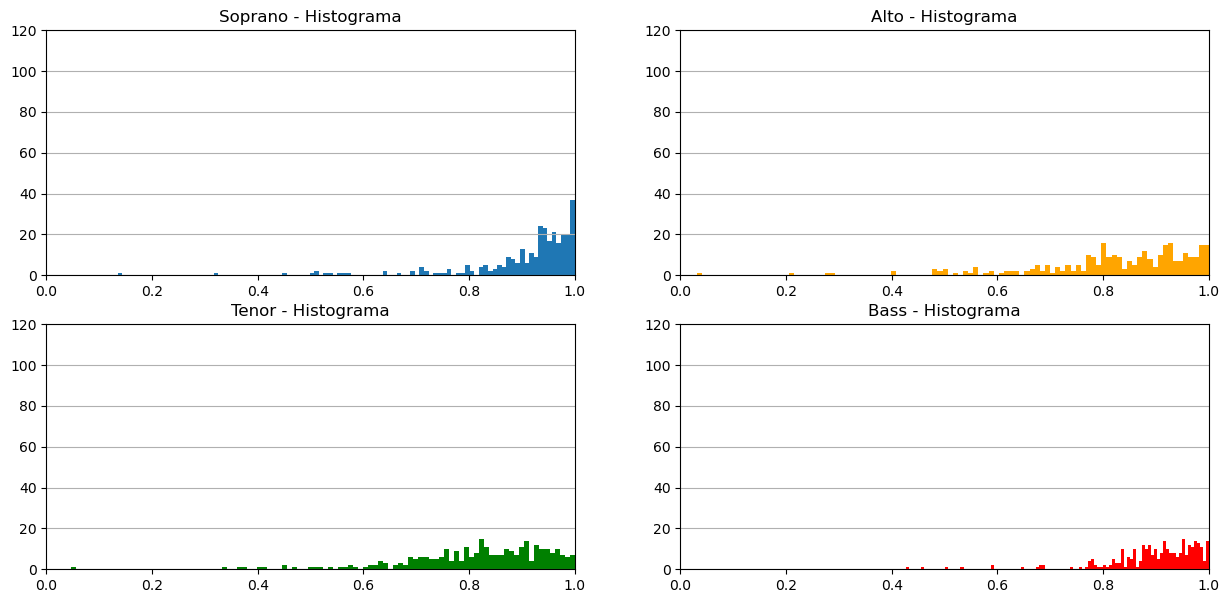

In [10]:
sscs.voice_f_histograms(f_scr_v2)

0.9406869539682565 0.8566863989335549 0.8334029402389307 0.9162194257513688


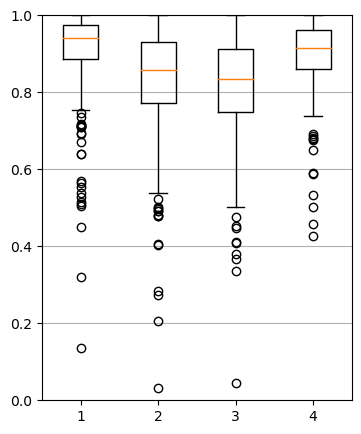

In [11]:
sscs.boxplot(f_scr_v2)

## 5 - Visualizing the "mask"

In [12]:
print(mask_voas_v2.layers[11].name)

conv_sigmoid_before_mask


In [13]:
mask_activations    = tf.keras.models.Model(inputs=mask_voas_v2.inputs,
                                            outputs=[   mask_voas_v2.layers[11].output,
                                                        mask_voas_v2.layers[12].output,
                                                        mask_voas_v2.layers[13].output])

#mask_activations.summary()

rand_song = sscs.pick_random_song(split='test')
mix, s, a, t, b = sscs.read_all_voice_splits(rand_song)

conv_sigmoid, upscale, mask = mask_activations.predict(mix)
conv_sigmoid = np.moveaxis(conv_sigmoid, 0, 1).reshape(90, -1, 16)
upscale = np.moveaxis(upscale, 0, 1).reshape(360, -1, 16)
mask = np.moveaxis(mask, 0, 1).reshape(360, -1, 16)
mix = np.moveaxis(mix, 0, 1).reshape(360, -1)
s = np.moveaxis(s, 0, 1).reshape(360, -1)
a = np.moveaxis(a, 0, 1).reshape(360, -1)
t = np.moveaxis(t, 0, 1).reshape(360, -1)
b = np.moveaxis(b, 0, 1).reshape(360, -1)

(pid=102781) 2023-07-11 00:23:02.598570: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:7630] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=102781) 2023-07-11 00:23:02.598616: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=102781) 2023-07-11 00:23:02.598627: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1500] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=102781) 2023-07-11 00:23:02.605332: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
(pid=102781) To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate c

2/2 [==============================] - 5s 181ms/step


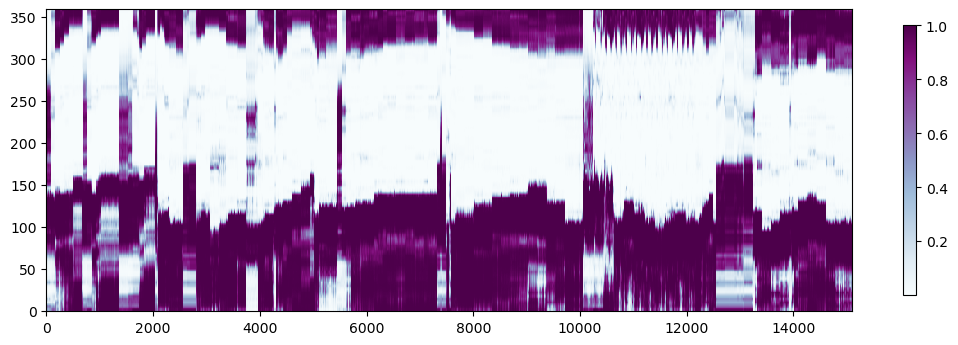

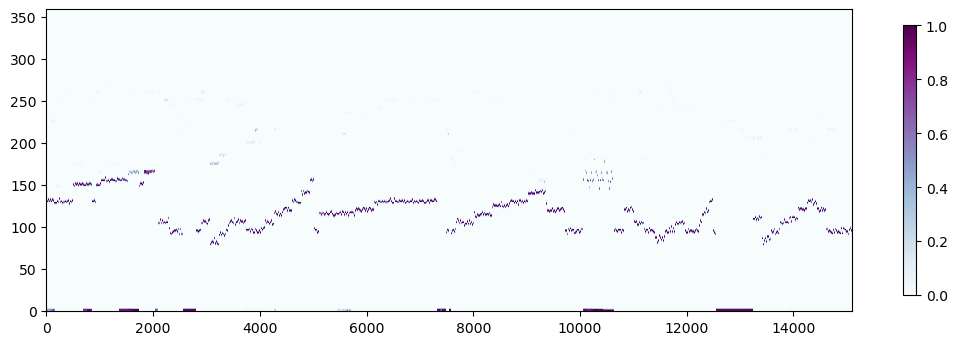

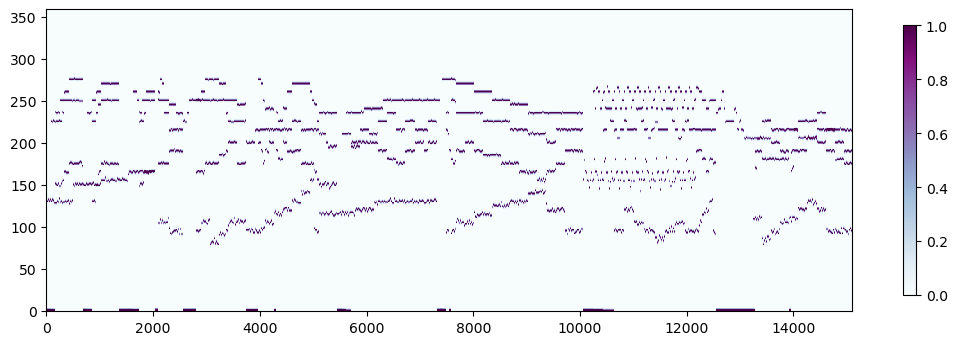

In [14]:
idx = 10
sscs.plot(upscale[:, :, idx], colorbar=True)
sscs.plot(mask[:, :, idx], colorbar=True)
sscs.plot(mix, colorbar=True)
#sscs.plot(s, colorbar=True)
#sscs.plot(a, colorbar=True)
#sscs.plot(t, colorbar=True)
#sscs.plot(b, colorbar=True)

## 6 - Playground

1/1 [==============================] - 0s 422ms/step
F-Scores:
Soprano: 0.9944195928571454
Alto: 0.9665178071428596
Tenor: 0.884207539285717
Bass: 0.9115512892857169



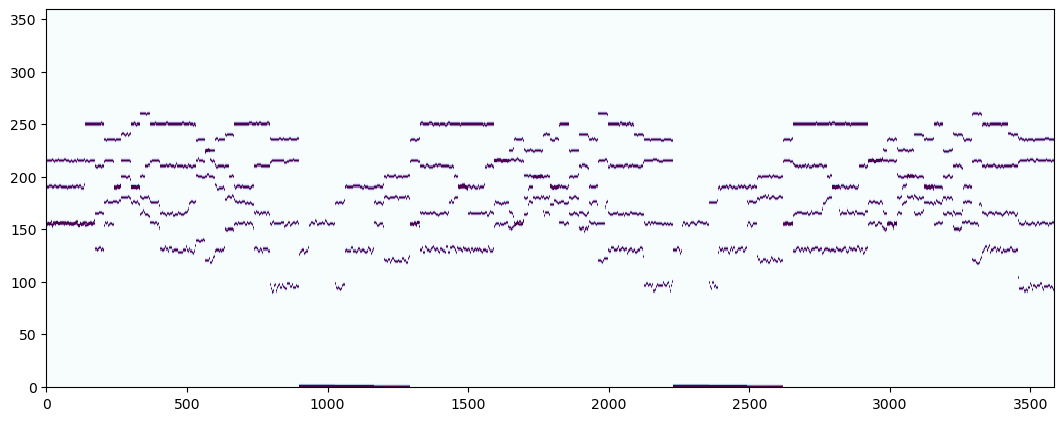

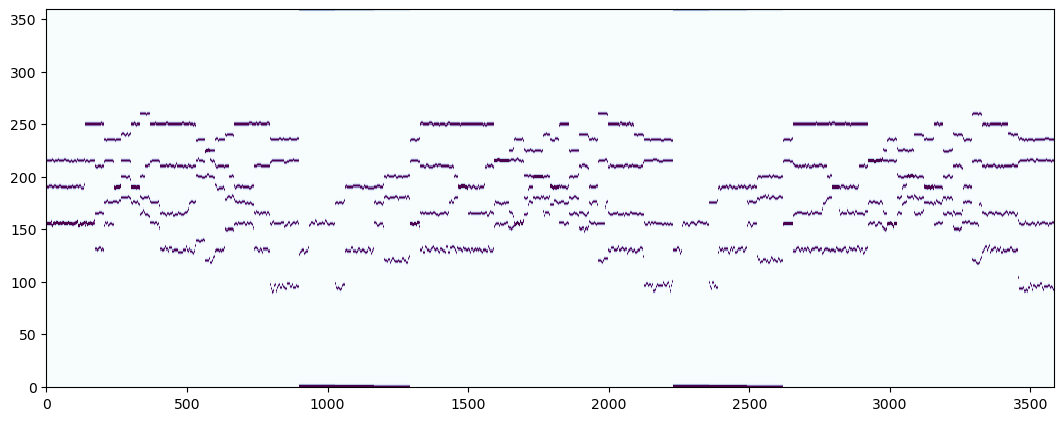

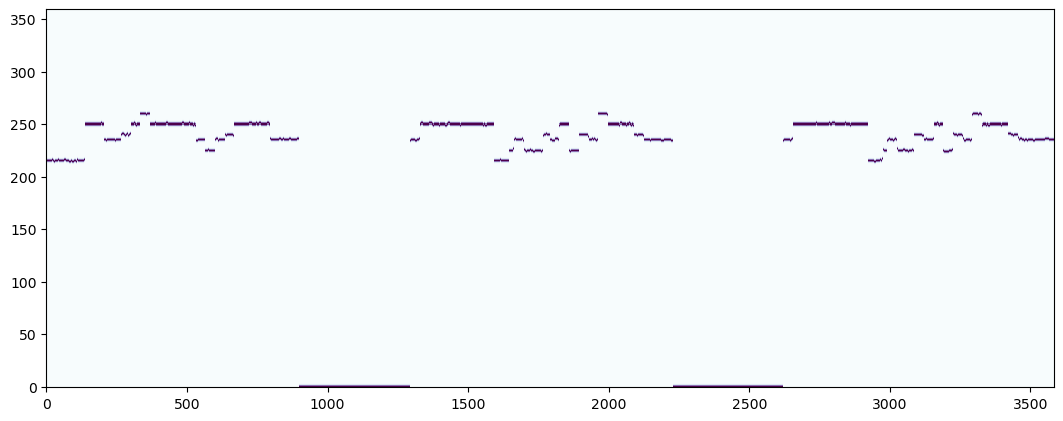

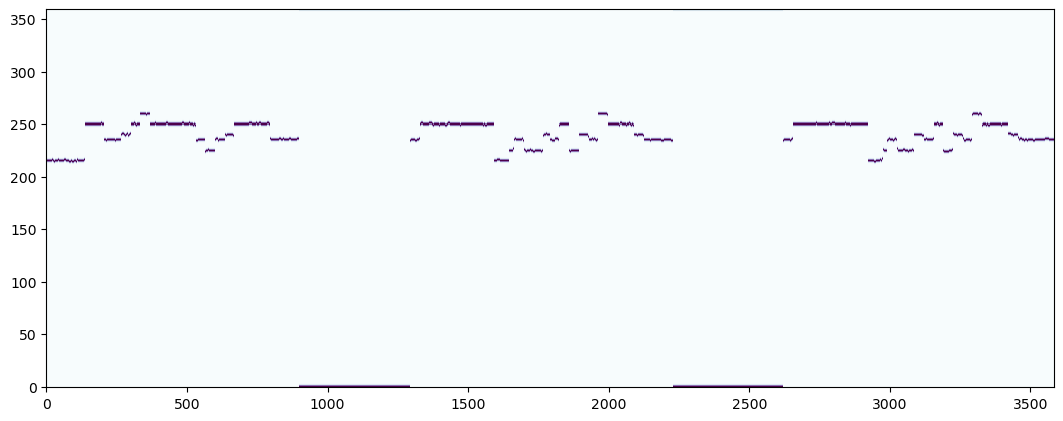

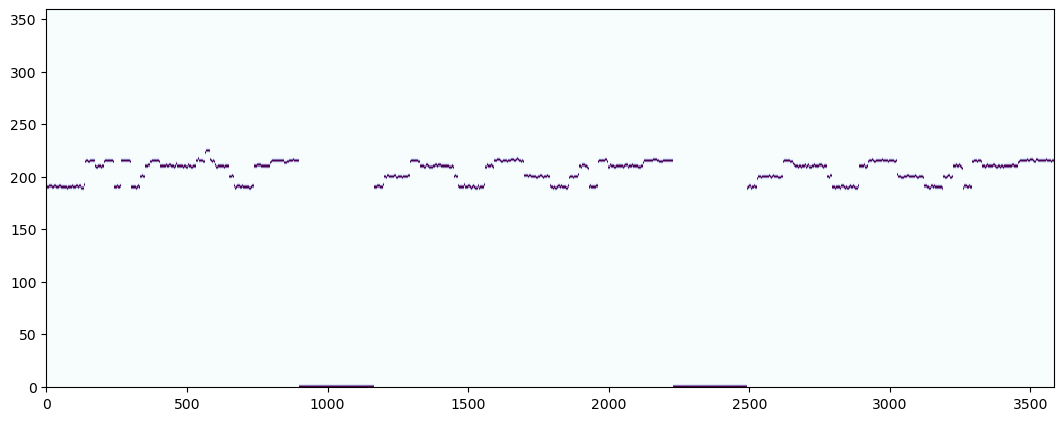

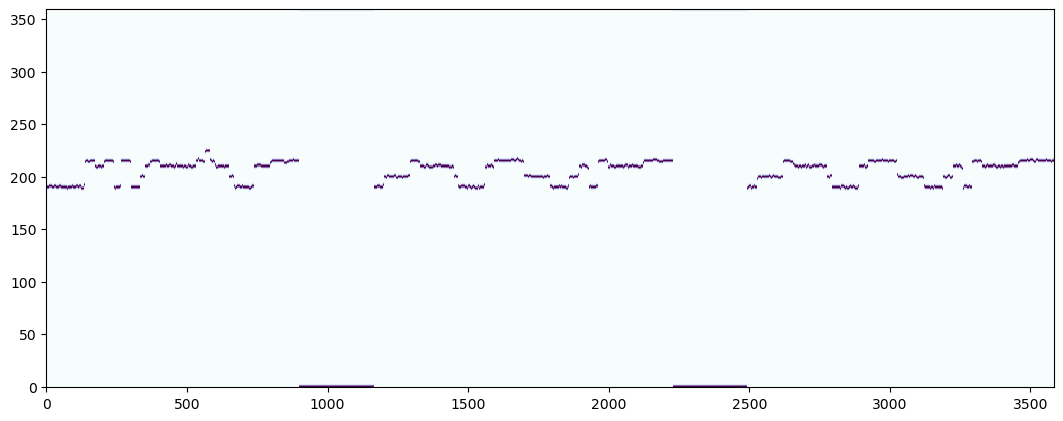

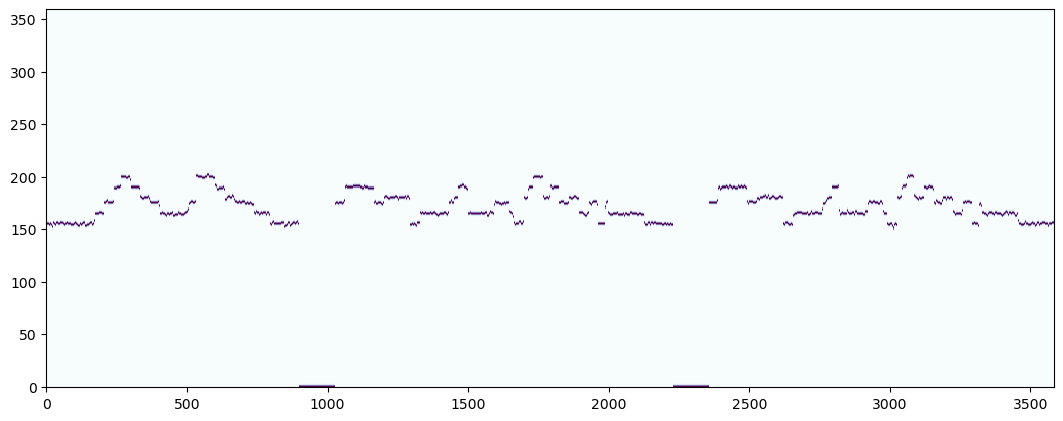

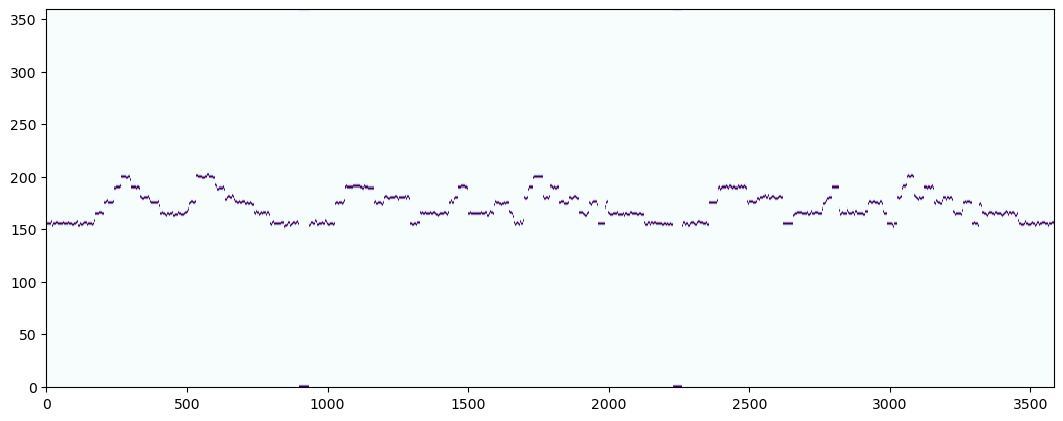

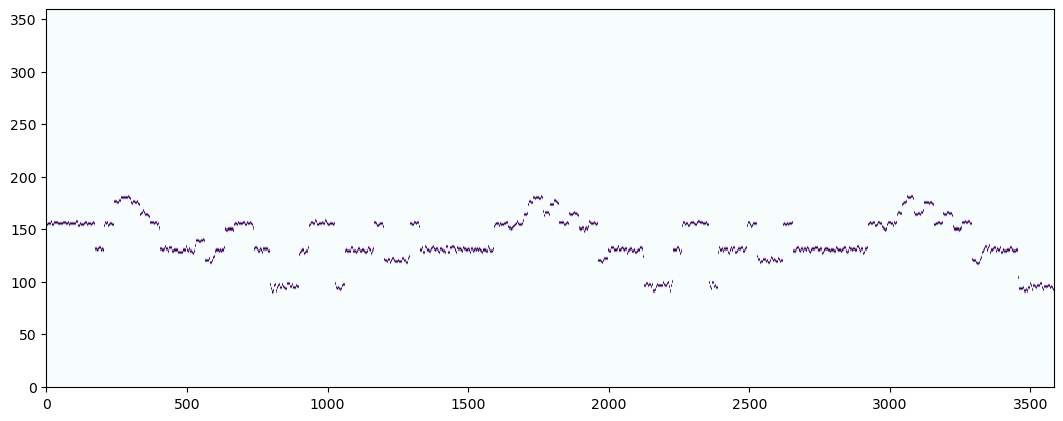

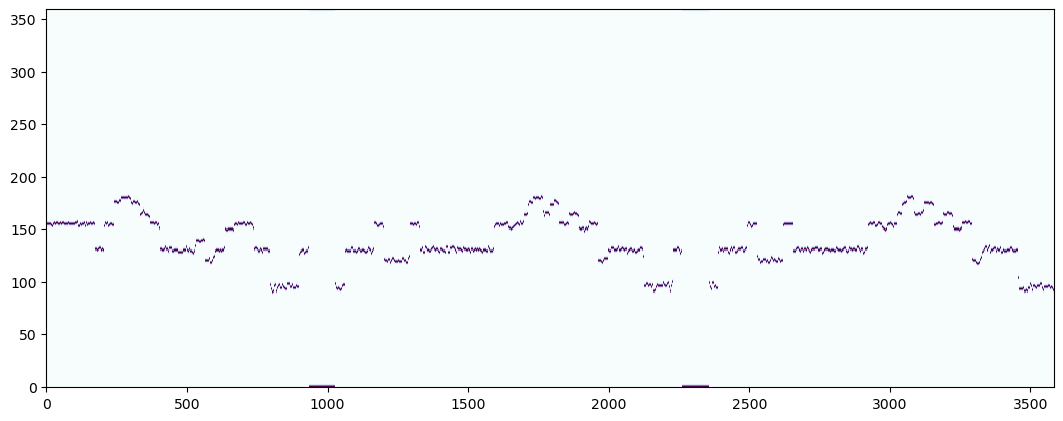

In [18]:
rand_song = sscs.pick_random_song(split='test')
mix, s, a, t, b = sscs.read_all_voice_splits(rand_song)

s_pred, a_pred, t_pred, b_pred = mask_voas_v2.predict(mix)

mix = np.moveaxis(mix, 0, 1).reshape(360, -1)
s = np.moveaxis(s, 0, 1).reshape(360, -1)
a = np.moveaxis(a, 0, 1).reshape(360, -1)
t = np.moveaxis(t, 0, 1).reshape(360, -1)
b = np.moveaxis(b, 0, 1).reshape(360, -1)

s_pred_postproc = sscs.prediction_postproc(s_pred).astype(np.float32)
a_pred_postproc = sscs.prediction_postproc(a_pred).astype(np.float32)
t_pred_postproc = sscs.prediction_postproc(t_pred).astype(np.float32)
b_pred_postproc = sscs.prediction_postproc(b_pred).astype(np.float32)
mix_pred_postproc = s_pred_postproc + a_pred_postproc + t_pred_postproc + b_pred_postproc
mix_pred_postproc = sscs.vectorized_downsample_limit(mix_pred_postproc)

s_fscore = sscs.f_score(s, s_pred_postproc)
a_fscore = sscs.f_score(a, a_pred_postproc)
t_fscore = sscs.f_score(t, t_pred_postproc)
b_fscore = sscs.f_score(b, b_pred_postproc)

print("F-Scores:")
print(f"Soprano: {s_fscore}")
print(f"Alto: {a_fscore}")
print(f"Tenor: {t_fscore}")
print(f"Bass: {b_fscore}")
print()

sscs.plot(mix)
sscs.plot(mix_pred_postproc)

sscs.plot(s)
sscs.plot(s_pred_postproc)

sscs.plot(a)
sscs.plot(a_pred_postproc)

sscs.plot(t)
sscs.plot(t_pred_postproc)

sscs.plot(b)
sscs.plot(b_pred_postproc)

sscs.song_to_midi(s, a, t, b, './MIDI/original.mid')
sscs.song_to_midi(s_pred_postproc, a_pred_postproc, t_pred_postproc, b_pred_postproc,
                  './MIDI/predicted.mid')